# 🕵️ Anomaly Detection & Root Cause Analysis Test
This notebook isolates the anomaly detection logic to verify if the model correctly flags issues and if the statistical analysis correctly identifies the root cause (e.g., High Ping vs Low Speed).

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
import sys
import datetime

# 1. Setup Paths
current_dir = os.getcwd()
# Ensure we are in the right relative path to find models
if 'server' not in current_dir:
    if os.path.exists('server/ai_engine'):
        os.chdir('server/ai_engine')
    elif os.path.exists('ai_engine'):
        os.chdir('ai_engine')

MODEL_DIR = 'models'
ANOMALY_PATH = os.path.join(MODEL_DIR, 'anomaly_model.pkl')

print(f"📂 Working Directory: {os.getcwd()}")
print("✅ Libraries loaded.")

📂 Working Directory: c:\Users\juice\Desktop\final_proj\backend\ai_engine
✅ Libraries loaded.


In [144]:
# 2. Load Model
if not os.path.exists(ANOMALY_PATH):
    print(f"❌ Model not found at {ANOMALY_PATH}. Run 'python trainer.py' first.")
else:
    data = joblib.load(ANOMALY_PATH)
    
    # Handle dictionary format vs legacy format
    if isinstance(data, dict):
        model = data['model']
        # Try to get saved stats, else we will calculate them from test data
        saved_stats = data.get('stats', {})
        features_list = data.get('features', [])
    else:
        model = data
        saved_stats = {}
        features_list = []

    # Define standard features if not saved
    if not features_list:
        features_list = ['lan_down', 'lan_up', 'wlan_down', 'wlan_up', 'lan_ping', 'wlan_ping', 'lan_dns', 'wlan_dns']

    print("✅ Model loaded.")
    print(f"   - Input Features: {features_list}")
    
    if saved_stats:
        print("   - ✅ Saved statistical baselines found.")
    else:
        print("   - ⚠️ No saved stats found. Will calculate baselines from test data.")

✅ Model loaded.
   - Input Features: ['lan_down', 'lan_up', 'wlan_down', 'wlan_up', 'lan_ping', 'wlan_ping', 'lan_dns', 'wlan_dns']
   - ⚠️ No saved stats found. Will calculate baselines from test data.


In [ ]:
def generate_scenarios(hours=24):
    dates = pd.date_range(end=datetime.datetime.now(), periods=hours, freq='H')
    df = pd.DataFrame({'timestamp': dates})
    
    # 1. Base Normal Data (High Capacity, Low Ping)
    # LAN: 800-1000 Mbps, Ping 2-5ms
    # WLAN: 300-500 Mbps, Ping 10-30ms
    lan_downs = []
    lan_pings = []
    
    for i in range(hours):
        # Normal fluctuation
        lan_downs.append(np.random.normal(900, 50)) 
        lan_pings.append(np.random.normal(3, 1))

    df['lan_down'] = lan_downs
    df['lan_up'] = df['lan_down'] * 0.9
    df['wlan_down'] = df['lan_down'] * 0.5
    df['wlan_up'] = df['wlan_down'] * 0.5
    df['lan_ping'] = lan_pings
    df['wlan_ping'] = df['lan_ping'] * 5.0
    df['lan_dns'] = 10
    df['wlan_dns'] = 15

    # 2. Inject Anomalies
    
    # Scenario A: LAN Speed Collapse (Hour 10)
    df.loc[10, 'lan_down'] = 10  # Drop to 10 Mbps
    df.loc[10, 'lan_up'] = 5
    
    # Simulating Speed Drop during peak hours
    df.loc[9:16, 'lan_down'] /= 2
    df.loc[9:16, 'lan_up'] /= 1.5
    # Scenario B: WLAN Latency Spike (Hour 18)
    df.loc[18, 'wlan_ping'] = 500 # Spike to 500ms
    
    return df

df = generate_scenarios()
print(f"📊 Generated {len(df)} hours of test data with injected anomalies at Index 10 (Speed) and 18 (Latency).")
df.head()

📊 Generated 24 hours of test data with injected anomalies at Index 10 (Speed) and 18 (Latency).


C:\Users\juice\AppData\Local\Temp\ipykernel_12056\859202624.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(end=datetime.datetime.now(), periods=hours, freq='H')


,timestamp,lan_down,lan_up,wlan_down,wlan_up,lan_ping,wlan_ping,lan_dns,wlan_dns
0,2026-01-29 10:37:27.288693,884.587738,796.128964,442.293869,221.146935,2.665981,13.329905,10,15
1,2026-01-29 11:37:27.288693,923.155589,830.840030,461.577794,230.788897,2.442503,12.212514,10,15
2,2026-01-29 12:37:27.288693,976.820405,879.138365,488.410203,244.205101,3.020374,15.101870,10,15
3,2026-01-29 13:37:27.288693,867.787445,781.008701,433.893723,216.946861,3.625199,18.125995,10,15
4,2026-01-29 14:37:27.288693,902.913288,812.621959,451.456644,225.728322,1.839240,9.196201,10,15


In [146]:
# 1. Normalize Data (Crucial: Model expects 0.0 - 1.0 range)
# We assume standard capacities if not provided by model metadata
max_caps = {
    'lan_down': 1000, 'lan_up': 1000, 
    'wlan_down': 500, 'wlan_up': 500,
    'lan_ping': 100, 'wlan_ping': 100, # Normalize ping to "100ms = 1.0"
    'lan_dns': 100, 'wlan_dns': 100
}

X = df.copy()
for col in features_list:
    if col in max_caps:
        X[col] = X[col] / max_caps[col]

# Select only features model knows
X_input = X[features_list]

# 2. Predict
preds = model.predict(X_input) # -1 = Anomaly
scores = model.decision_function(X_input) # Lower = More Anomalous

# 3. ROOT CAUSE ANALYSIS LOGIC
# Calculate stats from this test batch to serve as the baseline comparison
batch_stats = X_input.describe().loc[['mean', 'std']].to_dict()

print(f"{'TIME':<20} | {'STATUS':<10} | {'SCORE':<8} | {'ROOT CAUSE DIAGNOSIS'}")
print("-" * 100)

for i in range(len(df)):
    is_anomaly = preds[i] == -1
    score = scores[i]
    time_str = df.loc[i, 'timestamp'].strftime("%H:%M")
    
    status = "🚨 ANOMALY" if is_anomaly else "   OK"
    
    # Only analyze if anomaly
    diagnosis = "-"
    if is_anomaly:
        reasons = []
        for feat in features_list:
            val = X_input.loc[i, feat]
            
            # Use saved stats if exist, else use batch stats
            stat_source = saved_stats if saved_stats else batch_stats
            
            if feat in stat_source:
                avg = stat_source[feat]['mean']
                std = stat_source[feat]['std']
                if std == 0: std = 0.0001
                
                z_score = (val - avg) / std
                
                # RCA Thresholds
                if ('ping' in feat or 'dns' in feat) and z_score > 3:
                    raw_val = df.loc[i, feat]
                    reasons.append(f"{feat} High ({int(raw_val)}ms)")
                elif ('down' in feat or 'up' in feat) and z_score < -2:
                    raw_val = df.loc[i, feat]
                    reasons.append(f"{feat} Drop ({int(raw_val)}Mbps)")

        if not reasons:
            diagnosis = "⚠️ Complex Pattern (Metrics individually OK, but combination is rare)"
        else:
            diagnosis = ", ".join(reasons)

    # Print only anomalies or interesting rows
    if is_anomaly or i in [0, 10, 18]: 
        print(f"{time_str:<20} | {status:<10} | {score: .4f}   | {diagnosis}")

TIME                 | STATUS     | SCORE    | ROOT CAUSE DIAGNOSIS
----------------------------------------------------------------------------------------------------
13:57                |    OK      |  0.0332   | -
23:57                | 🚨 ANOMALY  | -0.0886   | lan_down Drop (10Mbps), lan_up Drop (5Mbps)
07:57                | 🚨 ANOMALY  | -0.0070   | wlan_ping High (500ms)


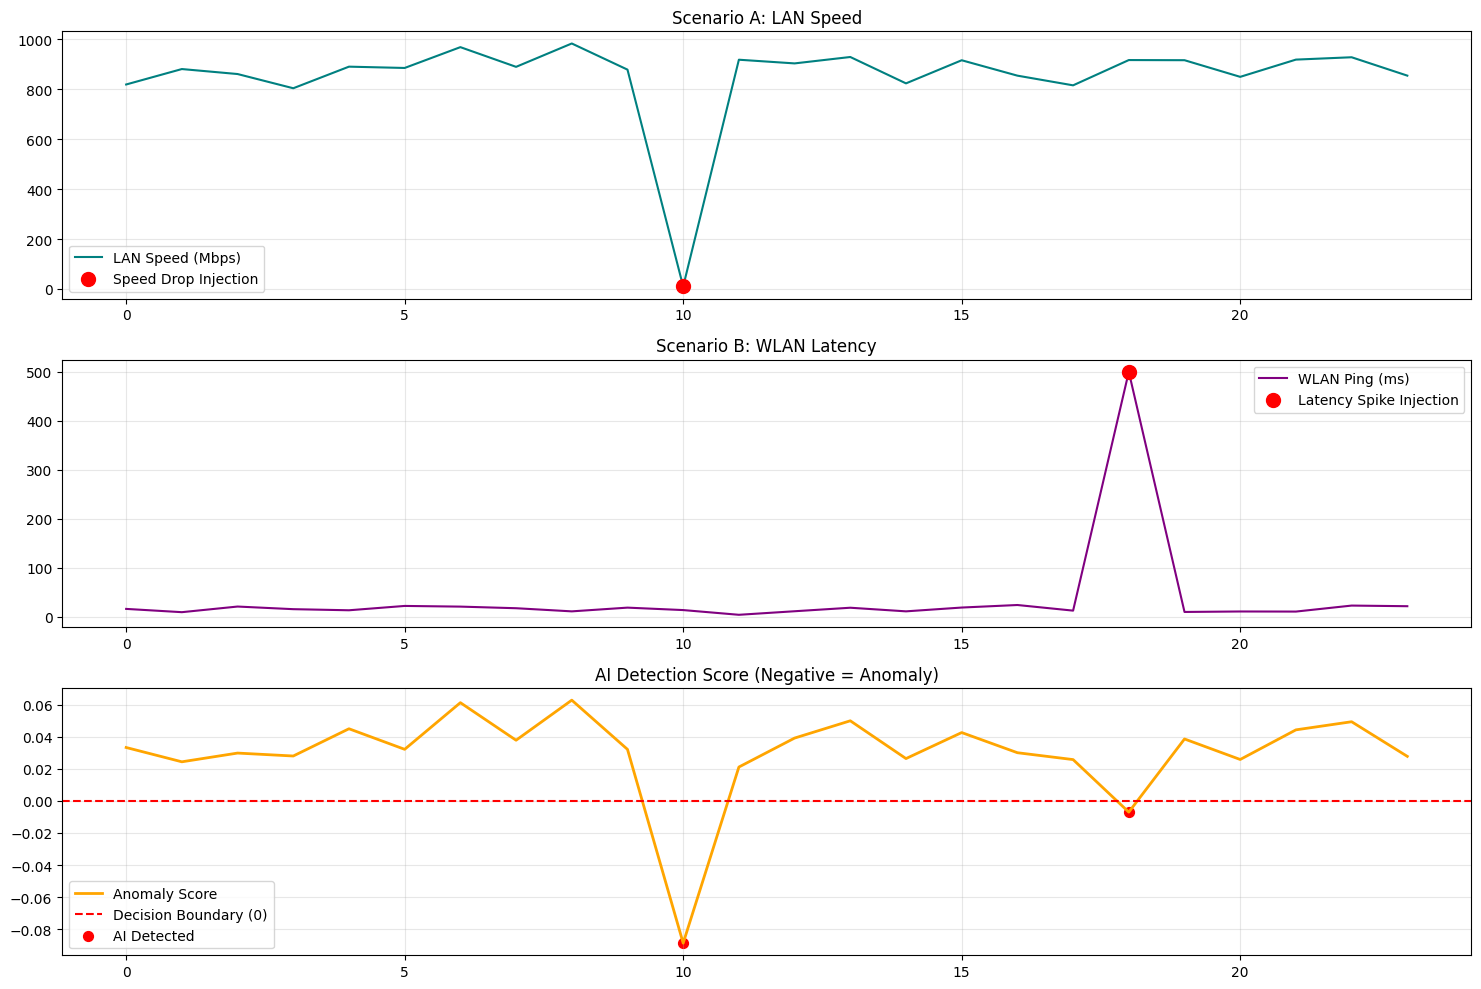

In [147]:
# Create combined dataframe for plotting
df['score'] = scores
df['anomaly'] = preds

plt.figure(figsize=(15, 10))

# 1. LAN Download Speed
plt.subplot(3, 1, 1)
plt.plot(df.index, df['lan_down'], label='LAN Speed (Mbps)', color='teal')
# Highlight Anomaly 1
plt.scatter(10, df.loc[10, 'lan_down'], color='red', s=100, zorder=5, label='Speed Drop Injection')
plt.title("Scenario A: LAN Speed")
plt.legend()
plt.grid(True, alpha=0.3)

# 2. WLAN Latency
plt.subplot(3, 1, 2)
plt.plot(df.index, df['wlan_ping'], label='WLAN Ping (ms)', color='purple')
# Highlight Anomaly 2
plt.scatter(18, df.loc[18, 'wlan_ping'], color='red', s=100, zorder=5, label='Latency Spike Injection')
plt.title("Scenario B: WLAN Latency")
plt.legend()
plt.grid(True, alpha=0.3)

# 3. AI Score
plt.subplot(3, 1, 3)
plt.plot(df.index, df['score'], label='Anomaly Score', color='orange', linewidth=2)
# Draw threshold
plt.axhline(0, color='red', linestyle='--', label='Decision Boundary (0)')
# Highlight detected points
anom_indices = df[df['anomaly'] == -1].index
plt.scatter(anom_indices, df.loc[anom_indices, 'score'], color='red', s=50, label='AI Detected')
plt.title("AI Detection Score (Negative = Anomaly)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Debug

In [148]:
# Cell 6: Test using Backend Data Fetcher
import sys
import os

# Ensure we can import from the sibling directory
sys.path.append(os.getcwd()) 


from trainer import fetch_real_data
print("✅ Imported fetcher successfully.")


✅ Imported fetcher successfully.


In [149]:
a,b,c = fetch_real_data()

🔌 Connecting to Prometheus at http://158.108.4.150:9090...
📥 Fetching last 14 days of INDIVIDUAL metrics...
   ...Processing and merging data frames...
   ...Calculating baselines...
✅ Fetched 12598 individual data points.


In [150]:
a

,timestamp,hostname,lan_down,lan_up,wlan_down,wlan_up,lan_ping,wlan_ping,hour,day_of_week,is_weekend,lan_dns,wlan_dns
0,2026-01-15 05:57:38,50Y-F4,0.984535,0.405741,0.695405,0.567656,0.026510,0.329603,5,3,0,0,0
1,2026-01-15 05:57:38,50Y-F5,1.000080,1.006526,0.575163,0.612361,0.261901,0.146579,5,3,0,0,0
2,2026-01-15 05:57:38,AGR-AGR5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5,3,0,0,0
3,2026-01-15 05:57:38,ARCH-B1,0.996832,1.000233,0.763710,0.598892,0.250489,0.305897,5,3,0,0,0
4,2026-01-15 05:57:38,BUS-B1,0.907996,0.972926,0.380744,0.252615,0.291733,0.425503,5,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12593,2026-01-29 05:57:38,SOC-SOC4,0.976021,0.953650,0.344927,0.026879,0.026203,0.269480,5,3,0,0,0
12594,2026-01-29 05:57:38,Saengchan-Dorm,0.988298,0.953119,0.000000,0.000000,0.287922,0.000000,5,3,0,0,0
12595,2026-01-29 05:57:38,Supannikar-Dorm,0.925303,0.965053,0.844290,0.729365,0.025839,0.586418,5,3,0,0,0
12596,2026-01-29 05:57:38,UFF-UFF3,0.989088,0.994757,0.953382,0.797848,0.246403,0.288903,5,3,0,0,0


In [151]:
b

,timestamp,lan_down,wlan_down,hour,day_of_week,is_weekend
0,2026-01-15 05:57:38,569.568181,36.193016,5,3,0
1,2026-01-15 06:57:38,569.227527,34.222616,6,3,0
2,2026-01-15 07:57:38,557.518495,34.460369,7,3,0
3,2026-01-15 08:57:38,563.432656,35.136031,8,3,0
4,2026-01-15 09:57:38,549.424833,39.283046,9,3,0
...,...,...,...,...,...,...
332,2026-01-29 01:57:38,558.019018,30.766556,1,3,0
333,2026-01-29 02:57:38,537.059562,30.424796,2,3,0
334,2026-01-29 03:57:38,558.690854,33.633716,3,3,0
335,2026-01-29 04:57:38,570.462744,34.207328,4,3,0


In [152]:
c

{'50Y-F4': {'lan_down_max': np.float64(784.9814202411227),
  'lan_up_max': np.float64(798.3040691105948),
  'wlan_down_max': np.float64(109.84568504252867),
  'wlan_up_max': np.float64(98.59672356023044),
  'lan_ping_max': 100,
  'wlan_ping_max': 200},
 '50Y-F5': {'lan_down_max': np.float64(89.64017175554541),
  'lan_up_max': np.float64(91.29813707915864),
  'wlan_down_max': np.float64(87.43751099751599),
  'wlan_up_max': np.float64(80.89047739264568),
  'lan_ping_max': 100,
  'wlan_ping_max': 200},
 'AGR-AGR5': {'lan_down_max': 1,
  'lan_up_max': 1,
  'wlan_down_max': 1,
  'wlan_up_max': 1,
  'lan_ping_max': 100,
  'wlan_ping_max': 200},
 'ARCH-B1': {'lan_down_max': np.float64(89.75077798230924),
  'lan_up_max': np.float64(91.30841472065454),
  'wlan_down_max': np.float64(90.41429444434478),
  'wlan_up_max': np.float64(79.94125172792214),
  'lan_ping_max': 100,
  'wlan_ping_max': 200},
 'BUS-B1': {'lan_down_max': np.float64(788.128663895866),
  'lan_up_max': np.float64(865.65922163293

# Cell 6

✅ Imported backend fetcher.
🔌 Fetching real training data (including normalization)...
🔌 Connecting to Prometheus at http://158.108.4.150:9090...
📥 Fetching last 7 days of INDIVIDUAL metrics...
   ...Processing and merging data frames...
   ...Calculating baselines...
✅ Fetched 6088 individual data points.
🎯 Selected Network: 50Y-F4
📊 Analyzing 169 hours of data for 50Y-F4...
🚨 Anomalies Detected: 10


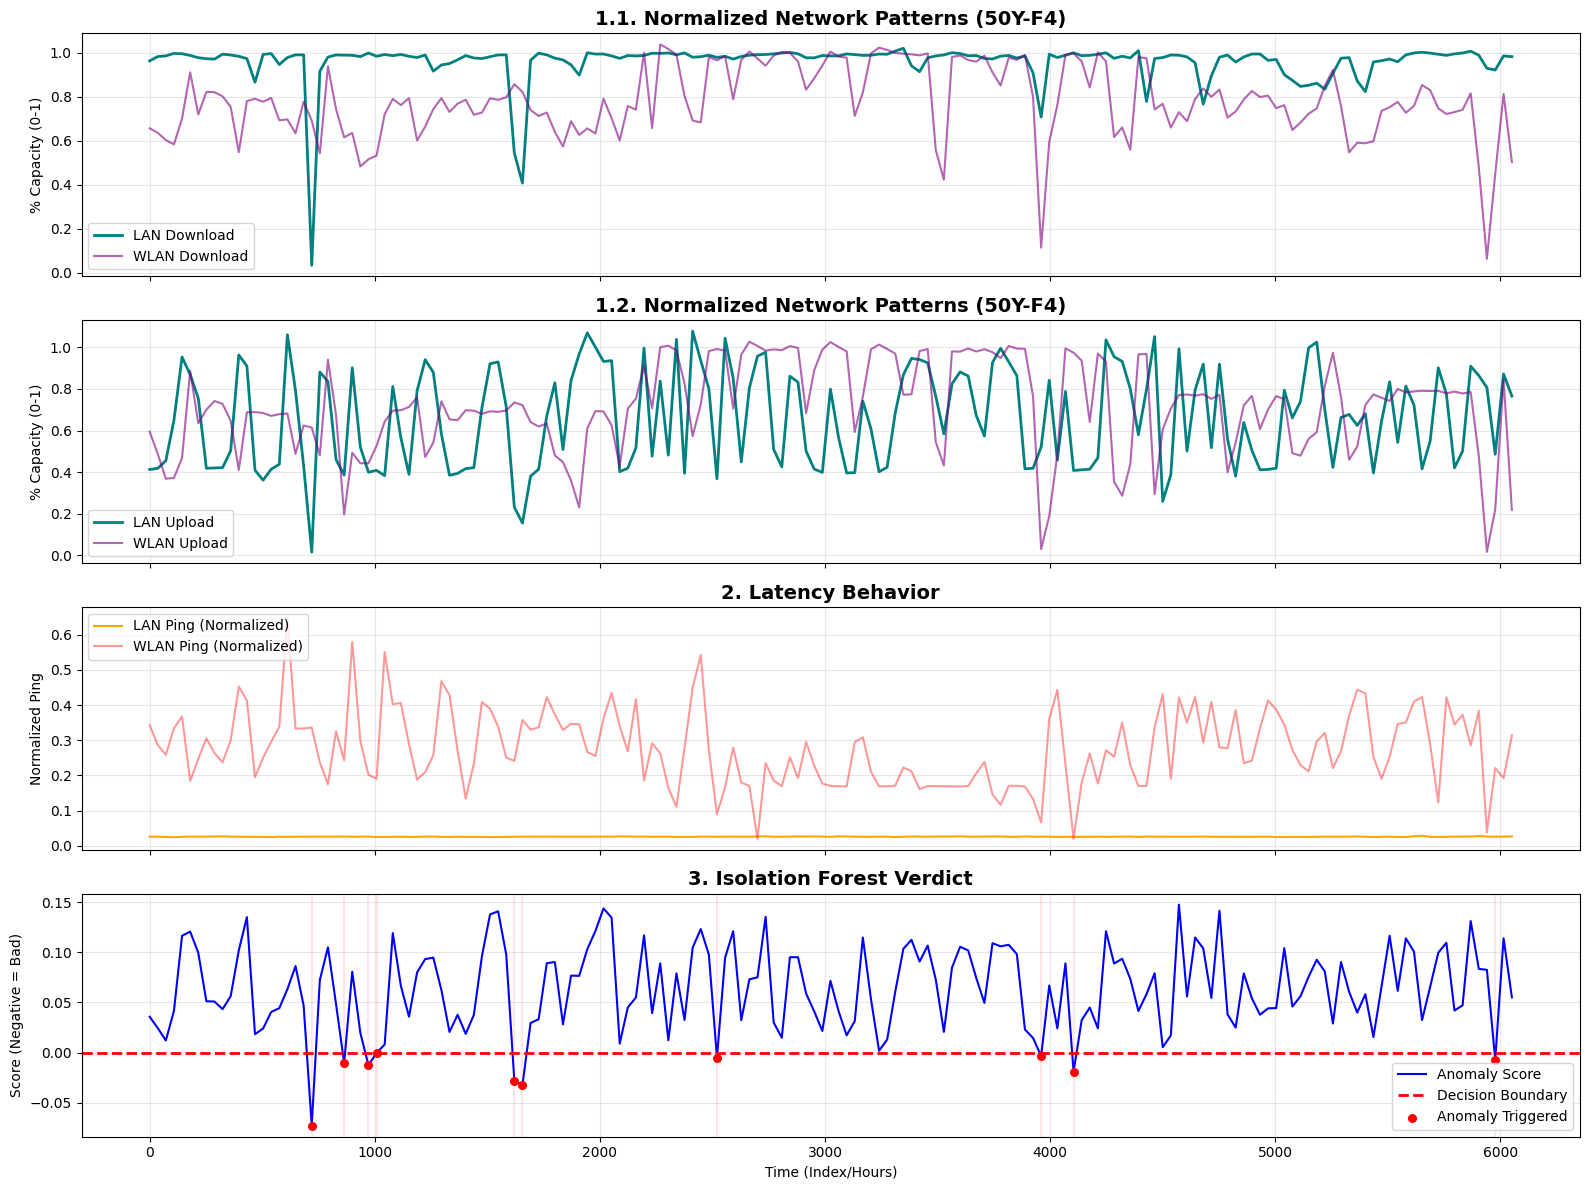

In [153]:
# Cell 6: Visualizing Real Data for a Single Network
import sys
import os

# Allow importing from sibling directories
sys.path.append(os.getcwd())

try:
    from ai_engine.trainer import fetch_real_data
    print("✅ Imported backend fetcher.")
except ImportError:
    # Fallback if running from root instead of server/
    sys.path.append(os.path.join(os.getcwd(), 'server'))
    from ai_engine.trainer import fetch_real_data
    print("✅ Imported backend fetcher (path adjusted).")

print("🔌 Fetching real training data (including normalization)...")
# 1. Fetch Data using the Trainer's logic
# This gets the 14-day history, normalized by probe capacity
df_all, df_n, baselines = fetch_real_data(days=7)

if df_all.empty:
    print("❌ No data returned from fetcher.")
else:
    # 2. Select a Specific Probe
    target_host = "Synthetic_Probe" # Default if no hostname column
    
    if 'hostname' in df_all.columns:
        # Get list of real probes found in Prometheus/Mock data
        unique_hosts = df_all['hostname'].unique()
        if len(unique_hosts) > 0:
            target_host = unique_hosts[0] # Pick the first one found
            print(f"🎯 Selected Network: {target_host}")
            
            # Filter DataFrame for just this probe
            df_probe = df_all[df_all['hostname'] == target_host].copy()
        else:
            df_probe = df_all.copy()
    else:
        # If running on pure synthetic data generation which might not have hostname col
        print("⚠️ Data has no 'hostname' column (likely synthetic). Using full dataset as one probe.")
        df_probe = df_all.copy()

    # 3. Prepare Features for Model
    # Remove non-numeric metadata columns before predicting
    # We keep 'timestamp' in the index usually, but if it's a column, drop it
    X_input = df_probe.copy()
    drop_cols = ['hostname', 'timestamp'] 
    for c in drop_cols:
        if c in X_input.columns: X_input = X_input.drop(columns=[c])

    # Ensure we strictly use the features the model expects
    if 'features' in globals() and features:
        # Fill missing with 0
        for f in features:
            if f not in X_input.columns: X_input[f] = 0
        X_input = X_input[features] # Reorder
    else:
        # Fallback if model details not loaded in Cell 2
        # Use standard anomaly columns
        fallback_cols = ['lan_down', 'lan_up', 'wlan_down', 'wlan_up', 'lan_ping', 'wlan_ping', 'lan_dns', 'wlan_dns']
        X_input = X_input[fallback_cols]

    # 4. Run AI Prediction
    scores = model.decision_function(X_input)
    df_probe['ai_score'] = scores
    anomalies = df_probe[df_probe['ai_score'] < 0]

    print(f"📊 Analyzing {len(df_probe)} hours of data for {target_host}...")
    print(f"🚨 Anomalies Detected: {len(anomalies)}")

    # 5. Visualization
    fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)

    # Graph AA: Input Data (Normalized Capacity)
    # This shows what the AI sees (0.0 to 1.0)
    axes[0].plot(df_probe.index, df_probe['lan_down'], color='teal', label='LAN Download', linewidth=2)
    axes[0].plot(df_probe.index, df_probe['wlan_down'], color='purple', alpha=0.6, label='WLAN Download')
    axes[0].set_title(f"1.1. Normalized Network Patterns ({target_host})", fontsize=14, fontweight='bold')
    axes[0].set_ylabel("% Capacity (0-1)")
    axes[0].legend(loc='lower left')
    axes[0].grid(True, alpha=0.3)

    # Graph AB: Input Data (Normalized Capacity)
    # This shows what the AI sees (0.0 to 1.0)
    axes[1].plot(df_probe.index, df_probe['lan_up'], color='teal', label='LAN Upload', linewidth=2)
    axes[1].plot(df_probe.index, df_probe['wlan_up'], color='purple', alpha=0.6, label='WLAN Upload')
    axes[1].set_title(f"1.2. Normalized Network Patterns ({target_host})", fontsize=14, fontweight='bold')
    axes[1].set_ylabel("% Capacity (0-1)")
    axes[1].legend(loc='lower left')
    axes[1].grid(True, alpha=0.3)

    # Graph B: Latency (Often the cause of anomalies)
    axes[2].plot(df_probe.index, df_probe['lan_ping'], color='orange', label='LAN Ping (Normalized)')
    axes[2].plot(df_probe.index, df_probe['wlan_ping'], color='red', alpha=0.4, label='WLAN Ping (Normalized)')
    axes[2].set_title("2. Latency Behavior", fontsize=14, fontweight='bold')
    axes[2].set_ylabel("Normalized Ping")
    axes[2].legend(loc='upper left')
    axes[2].grid(True, alpha=0.3)

    # Graph C: AI Verdict
    axes[3].plot(df_probe.index, df_probe['ai_score'], color='blue', label='Anomaly Score')
    axes[3].axhline(0, color='red', linestyle='--', linewidth=2, label='Decision Boundary')
    
    # Highlight anomalies with red dots
    if not anomalies.empty:
        axes[3].scatter(anomalies.index, anomalies['ai_score'], color='red', s=30, zorder=5, label='Anomaly Triggered')
        
        # Highlight regions on the graph
        for idx in anomalies.index:
            axes[3].axvline(idx, color='red', alpha=0.1)

    axes[3].set_title("3. Isolation Forest Verdict", fontsize=14, fontweight='bold')
    axes[3].set_ylabel("Score (Negative = Bad)")
    axes[3].set_xlabel("Time (Index/Hours)")
    axes[3].legend(loc='lower right')
    axes[3].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()